In [3]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

class Expert(nn.Module):
    def __init__(self, d_model, nhead, num_layers, input_size, output_size):
        super(Expert, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.input_projection = nn.Linear(input_size, d_model)
        self.output_projection = nn.Linear(d_model, output_size)

    def forward(self, x):
        x = self.input_projection(x)
        x = self.transformer_encoder(x)
        return self.output_projection(x)

class MixtureOfExperts(nn.Module):
    def __init__(self, num_experts, d_model, nhead, num_layers, input_size, output_size):
        super(MixtureOfExperts, self).__init__()
        self.experts = nn.ModuleList([Expert(d_model, nhead, num_layers, input_size, output_size) for _ in range(num_experts)])
        self.gates = nn.Linear(input_size, num_experts)

    def forward(self, x):
        weights = F.softmax(self.gates(x), dim=1)
        outputs = torch.stack([expert(x) for expert in self.experts], dim=2)
        return (weights.unsqueeze(2) * outputs).sum(dim=2)

In [6]:
### Naive data simulation and test

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
model = MixtureOfExperts(num_experts=10, d_model=512, nhead=8, num_layers=6, input_size=512, output_size=512)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


torch.manual_seed(42)

n_samples = 100
input_dim = 10
output_dim = 1

# Generate input features x
x = torch.randn(n_samples, input_dim)
moe = MoE(
    input_dim=input_dim,
    output_dim=output_dim,
    num_experts=4,
    d_model=512,
    nhead=8,
    num_layers=6,
    top_k=2
)

# Generate target y_1 as a nonlinear function of x
# (e.g., combination of sin, square, and linear components)
with torch.no_grad():
    y_1 = (
        torch.sin(x[:, 0]) +
        torch.square(x[:, 1]) +
        0.5 * x[:, 2] +
        0.1 * torch.randn(n_samples)  # noise
    ).unsqueeze(1)  # Shape: [n_samples, 1]


# Wrap x and y_1 into a dataset
dataset = TensorDataset(x, y_1)

# Use DataLoader for batching
batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

y_pred = moe(x)

print("Pred shape:", y_pred.shape)
print("Target shape:", y_1.shape)

/home/shijimao/anaconda3/envs/stat293/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Pred shape: torch.Size([100, 1])
Target shape: torch.Size([100, 1])


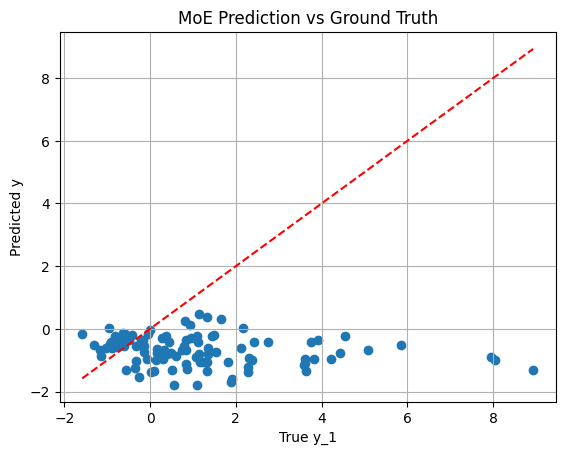

In [18]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(moe.parameters(), lr=1e-3)


n_epochs = 50

for epoch in range(n_epochs):
    total_loss = 0.0
    moe.train()

    for batch_x, batch_y in dataloader:
        optimizer.zero_grad()
        pred_y = moe(batch_x)
        loss = loss_fn(pred_y, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_x.size(0)

    avg_loss = total_loss / len(dataset)
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.4f}")

Epoch 1/50, Loss: 251.8305
Epoch 2/50, Loss: 7.7350
Epoch 3/50, Loss: 5.2233
Epoch 4/50, Loss: 4.6946
Epoch 5/50, Loss: 4.4399
Epoch 6/50, Loss: 4.1741
Epoch 7/50, Loss: 4.0037
Epoch 8/50, Loss: 4.3245
Epoch 9/50, Loss: 4.3595
Epoch 10/50, Loss: 3.9858
Epoch 11/50, Loss: 4.1253
Epoch 12/50, Loss: 4.0904
Epoch 13/50, Loss: 4.5884
Epoch 14/50, Loss: 5.2132
Epoch 15/50, Loss: 5.1471
Epoch 16/50, Loss: 4.3960
Epoch 17/50, Loss: 4.3824
Epoch 18/50, Loss: 4.2401
Epoch 19/50, Loss: 4.0166
Epoch 20/50, Loss: 4.2433
Epoch 21/50, Loss: 5.0364
Epoch 22/50, Loss: 5.1377
Epoch 23/50, Loss: 4.2895
Epoch 24/50, Loss: 4.1380
Epoch 25/50, Loss: 3.9719
Epoch 26/50, Loss: 4.0614
Epoch 27/50, Loss: 4.0652
Epoch 28/50, Loss: 3.9310
Epoch 29/50, Loss: 4.1068
Epoch 30/50, Loss: 4.5606
Epoch 31/50, Loss: 4.0467
Epoch 32/50, Loss: 4.0165
Epoch 33/50, Loss: 4.1530
Epoch 34/50, Loss: 4.2464
Epoch 35/50, Loss: 4.9127
Epoch 36/50, Loss: 4.1884
Epoch 37/50, Loss: 4.1163
Epoch 38/50, Loss: 3.9597
Epoch 39/50, Loss: 

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Expert(nn.Module):
    def __init__(self, d_model, nhead, num_layers, input_dim, output_dim):
        super(Expert, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.input_projection = nn.Linear(input_dim, d_model)
        self.output_projection = nn.Linear(d_model, output_dim)

    def forward(self, x):
        x = self.input_projection(x)
        x = self.transformer_encoder(x.unsqueeze(0)).squeeze(0)  # Transformer expects (S, N, E), adjusting for N=1
        return self.output_projection(x)

class Router(nn.Module):
    def __init__(self, input_dim, num_experts):
        super().__init__()
        self.layer = nn.Linear(input_dim, num_experts)
    
    def forward(self, x):
        return F.softmax(self.layer(x), dim=-1)

class MoE(nn.Module):
    def __init__(self, input_dim, output_dim, num_experts, d_model, nhead, num_layers, top_k=2):
        super().__init__()
        self.experts = nn.ModuleList([Expert(d_model, nhead, num_layers, input_dim, output_dim) for _ in range(num_experts)])
        self.router = Router(input_dim, num_experts)
        self.top_k = top_k
    
    def forward(self, x):
        batch_size = x.size(0)
        routing_weights = self.router(x)
        
        topk_vals, topk_indices = torch.topk(routing_weights, self.top_k, dim=1)
        topk_vals_normalized = topk_vals / topk_vals.sum(dim=1, keepdim=True)
        
        outputs = torch.zeros(batch_size, output_dim, device=x.device)
        
        for i, expert in enumerate(self.experts):
            expert_mask = (topk_indices == i).float()
            if expert_mask.any():
                expert_mask = expert_mask.unsqueeze(-1).expand(-1, -1, x.size(1))
                inputs_to_expert = x.unsqueeze(1).repeat(1, self.top_k, 1) * expert_mask
                inputs_to_expert = inputs_to_expert.view(-1, x.size(1))
                expert_outputs = expert(inputs_to_expert).view(batch_size, self.top_k, -1)
                
                # Weight outputs by normalized routing probability and sum across selected experts
                weighted_expert_outputs = expert_outputs * topk_vals_normalized.unsqueeze(-1)
                outputs += weighted_expert_outputs.sum(dim=1)
        
        return outputs

In [9]:
import numpy as np
a = torch.from_numpy(np.array([[1, 2, 4, 2, 0.5, 0.1],
                                   [4, 5, 3, 8, 0.6, 0.43],
                                   [6, 3, 2, 9, 0.12, 0.32],
                                   [9, 1, 1, 1, 0.12, 0.45],
                                   [8, 3, 1, 4, 0.21, 0.67]]))
user_cate_dict = {'user_id': (11, 0), 'user_list': (12, 3), 'user_num': (1, 4)}
item_cate_dict = {'item_id': (8, 1), 'item_cate': (6, 2), 'item_num': (1, 5)}
mmoe = MoE(user_cate_dict, item_cate_dict,number)
outs = mmoe(a)
print(outs)

TypeError: MoE.__init__() missing 1 required positional argument: 'hidden_dim'

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FFNExpert(nn.Module):
    """An FFN expert similar to the FFN in Transformer Encoder Layers."""
    def __init__(self, d_model, hidden_dim):
        super(FFNExpert, self).__init__()
        self.input_projection = nn.Linear(d_model, hidden_dim)
        self.output_projection = nn.Linear(hidden_dim, d_model)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.input_projection(x)
        x = self.activation(x)
        x = self.output_projection(x)
        return x

class Router(nn.Module):
    """Router to distribute tokens to experts."""
    def __init__(self, d_model, num_experts):
        super(Router, self).__init__()
        self.layer = nn.Linear(d_model, num_experts)
    
    def forward(self, x):
        return F.softmax(self.layer(x), dim=-1)

class MoE(nn.Module):
    def __init__(self, d_model, num_experts, hidden_dim, top_k=2):
        super(MoE, self).__init__()
        self.experts = nn.ModuleList([FFNExpert(d_model, hidden_dim) for _ in range(num_experts)])
        self.router = Router(d_model, num_experts)
        self.top_k = top_k
    
    def forward(self, x):
        # Flatten to (batch_size*seq_len, d_model) for the router
        routing_weights = self.router(x)
        topk_vals, topk_indices = torch.topk(routing_weights, self.top_k, dim=1)
        topk_vals_normalized = topk_vals / topk_vals.sum(dim=1, keepdim=True)
        
        output = torch.zeros_like(x)
        for i, expert in enumerate(self.experts):
            expert_mask = (topk_indices == i).float()
            if expert_mask.any():
                inputs_to_expert = x * expert_mask.unsqueeze(-1)
                expert_output = expert(inputs_to_expert)
                output += expert_output * topk_vals_normalized.unsqueeze(-1)
        
        return output

class TransformerEncoderLayerWithMoE(nn.Module):
    def __init__(self, d_model, nhead, num_experts, hidden_dim, dropout=0.1, top_k=2):
        super(TransformerEncoderLayerWithMoE, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.moe = MoE(d_model, num_experts, hidden_dim, top_k=top_k)
        # Implementation of Feedforward model
        self.dropout = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
    
    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        src2 = self.self_attn(src, src, src, attn_mask=src_mask,
                              key_padding_mask=src_key_padding_mask)[0]
        src = src + self.dropout(src2)
        src = self.norm1(src)
        
        # Utilize mixture of experts 
        src2 = self.moe(src)
        src = src + self.dropout(src2)
        src = self.norm2(src)
        return src

In [7]:
from Simulation.data_simulation_base import simulate_JM_base
n_sim = 1
I = 1000
obstime = [0,1,2,3,4,5,6,7,8,9,10]
landmark_times = [1,2,3,4,5]
pred_windows = [1,2,3]
scenario = "none" # ["none", "interaction", "nonph"]
from sklearn.preprocessing import MinMaxScaler
from data_simulation_base import simulate_JM_base
data_all = simulate_JM_base(I=I, obstime=obstime, opt=scenario, seed=n_sim)
data = data_all[data_all.obstime <= data_all.time]

## split train/test
random_id = range(I) #np.random.permutation(range(I))
train_id = random_id[0:int(0.7*I)]
test_id = random_id[int(0.7*I):I]

train_data = data[data["id"].isin(train_id)]
test_data = data[data["id"].isin(test_id)]
x1= train_data[['X1','X2']]
y = train_data[['Y1','Y2','Y3']]

In [27]:
train_data.head()

,id,visit,obstime,predtime,time,event,Y1,Y2,Y3,X1,X2,pred_Y1,pred_Y2,pred_Y3,true
0,0,0,0,0,9,True,11.943728,-3.032593,2.760192,1.0,0.680195,11.943728,-3.032593,2.760192,1.000000
1,0,1,1,1,9,True,12.255357,-5.431790,4.225383,1.0,0.680195,12.255357,-5.431790,4.225383,0.999397
2,0,2,2,2,9,True,12.491947,-6.953460,2.854653,1.0,0.680195,12.491947,-6.953460,2.854653,0.998135
3,0,3,3,3,9,True,16.406431,-8.508030,4.766191,1.0,0.680195,16.406431,-8.508030,4.766191,0.995494
4,0,4,4,4,9,True,16.632347,-9.813989,5.816555,1.0,0.680195,16.632347,-9.813989,5.816555,0.989983


In [1]:
import sys
import torch
sys.path.append("/home/shijimao/TransformerJM/Models")
sys.path.append("/home/shijimao/TransformerJM/Simulation")
from Models.Transformer.functions import (get_tensors, get_mask, init_weights, get_std_opt)
from Models.Transformer.loss import (long_loss, surv_loss)
from Models.metrics import (AUC, Brier, MSE)
import numpy as np
torch.manual_seed(0)



In [ ]:
import warnings 
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
n_epoch = 25
batch_size = 32
from datetime import datetime

n_epoch = 50
batch_size = 32
    
    
loss_values = []
loss1_list = []
loss2_list = []
for epoch in range(n_epoch):
    running_loss = 0
    train_id = np.random.permutation(train_id)
    for batch in range(0, len(train_id), batch_size):
        optimizer.zero_grad()
            
        indices = train_id[batch:batch+batch_size]
        batch_data = train_data[train_data["id"].isin(indices)]
            
        batch_long, batch_base, batch_mask, batch_e, batch_t, obs_time = get_tensors(batch_data.copy())
        batch_long_inp = batch_long[:,:-1,:].to('cuda')
        batch_long_out = batch_long[:,1:,:].to('cuda')
        batch_base = batch_base[:,:-1,:].to('cuda')
        batch_mask_inp = get_mask(batch_mask[:,:-1]).to('cuda')
        batch_mask_out = batch_mask[:,1:].unsqueeze(2).to('cuda') 
        obs_time = obs_time.to('cuda')
        yhat_long, yhat_surv = model(batch_long_inp, batch_base, batch_mask_inp,
                        obs_time[:,:-1].to('cuda'), obs_time[:,1:].to('cuda'))
        
        loss1 = long_loss(yhat_long, batch_long_out, batch_mask_out)
        loss2 = surv_loss(yhat_surv, batch_mask, batch_e)
        
        #loss = loss1 + loss2
        loss = multi_task_loss(loss1, loss2)
        
        loss.backward()
        scheduler.step()
        running_loss += loss
        loss1_list.append(loss1.tolist())
        loss2_list.append(loss2.tolist())
    loss_values.append(running_loss.tolist())
plt.plot((loss_values-np.min(loss_values))/(np.max(loss_values)-np.min(loss_values)), 'b-')


NameError: name 'optimizer' is not defined

In [ ]:
import torch
import torch.nn as nn

import torch.nn.functional as F



class Decoder(nn.Module):
    """
    Decoder Block
    
    Parameters
    ----------
    d_long:
        Number of longitudinal outcomes
    d_base:
        Number of baseline / time-independent covariates
    d_model:
        Dimension of the input vector
    nhead:
        Number of heads
    num_decoder_layers:
        Number of decoder layers to stack
    dropout:
        The dropout value
    """
    def __init__(self,
                 d_long,
                 d_base,
                 d_model,
                 nhead,
                 num_decoder_layers,
                 dropout):
        super().__init__()
        
        self.embedding = nn.Sequential(
            nn.Linear(d_long + d_base, d_model),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model)
            )
        
        self.decoder_layers = nn.ModuleList([Decoder_Layer(d_model,nhead,dropout)
                                             for _ in range(num_decoder_layers)])
        
    def forward(self, long, base, mask, obs_time):
        # Concatenate longitudinal and baseline data
        x = torch.cat((long, base), dim=2)
        
        # Linear Embedding
        x = self.embedding(x)
        
        # Positional Embedding

        x = x + positional_encoding(
            x.shape[0], x.shape[1], x.shape[2], obs_time)
        
        # Decoder Layers
        for layer in self.decoder_layers:
            decoding = layer(x, x, mask)

        return decoding


class Decoder_p(nn.Module):
    """
    Decoder Block
    
    Parameters_
    ----------
    d_model:
        Dimension of the input vector
    nhead:
        Number of heads
    num_decoder_layers:
        Number of decoder layers to stack
    dropout:
        The dropout value
    """
    def __init__(self,
                 d_model,
                 nhead,
                 num_decoder_layers,
                 dropout):
        super().__init__()

        self.decoder_layers = nn.ModuleList([Decoder_Layer(d_model,nhead,dropout)
                                             for _ in range(num_decoder_layers)])
        
    def forward(self, q, kv, mask, pred_time):
        # Positional Embedding
        
        q = q + positional_encoding(
            q.shape[0], q.shape[1], q.shape[2], pred_time)
        
        # Decoder Layers
        for layer in self.decoder_layers:
            x = layer(q, kv,mask)

        return x
        




class Transformer1(nn.Module):
    """
    An adaptation of the transformer model (Attention is All you Need)
    for survival analysis.
    
    Parameters
    ----------
    d_long:
        Number of longitudinal outcomes
    d_base:
        Number of baseline / time-independent covariates
    d_model:
        Dimension of the input vector (post embedding)
    nhead:
        Number of heads
    num_decoder_layers:
        Number of decoder layers to stack
    dropout:
        The dropout value
    """
    def __init__(self,
                 d_long,
                 d_base,
                 d_model = 32,
                 nhead = 4,
                 n_expert = 4,
                 d_ff = 64,  
                 num_decoder_layers = 3,
                 dropout = 0.2):
        super().__init__()
        self.decoder = Decoder(d_long, d_base, d_model, nhead, num_decoder_layers, dropout)

        self.decoder_pred = Decoder_p(d_model, nhead, 1, dropout)
        
        self.long = nn.Sequential(
            nn.Linear(d_model, d_long)
        )
        
        self.surv = nn.Sequential(
            nn.Linear(d_model, 1)
        )
        self.mmoe_head = MMoEHead(
            d_model=d_model,
            d_ff=d_ff,
            n_expert=n_expert,
            d_long=d_long
        )

    def forward(self, long, base, mask, obs_time, pred_time, use_moe = True):        
        # Decoder Layers
        x = self.decoder(long, base, mask, obs_time)
        
        # Decoder Layer with prediction time embedding
        
        x = self.decoder_pred(x, x, mask, pred_time)

        if use_moe:
            long, surv = self.mmoe_head(x)
        else:
            long = self.long(x)
            surv = torch.sigmoid(self.surv(x))
        return long, surv
    

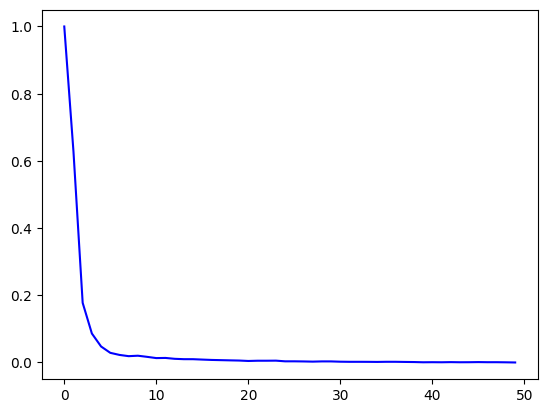

In [21]:
import matplotlib.pyplot as plt
model = Transformer1(d_long=3, d_base=2, d_model=32, nhead=4,
                    num_decoder_layers=7)
model.to('cuda')
model.apply(init_weights)
model = model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9)
scheduler = get_std_opt(optimizer, d_model=32, warmup_steps=200, factor=0.2)
n_epoch = 50
batch_size = 32
import warnings 
warnings.filterwarnings("ignore")    
    
loss_values = []
loss_test = []
loss1_list = []
loss2_list = []

for epoch in range(n_epoch):
    running_loss = 0
    train_id = np.random.permutation(train_id)
    for batch in range(0, len(train_id), batch_size):
        optimizer.zero_grad()
            
        indices = train_id[batch:batch+batch_size]
        batch_data = train_data[train_data["id"].isin(indices)]
            
        batch_long, batch_base, batch_mask, batch_e, batch_t, obs_time = get_tensors(batch_data.copy())
        batch_long_inp = batch_long[:,:-1,:].to('cuda')
        batch_long_out = batch_long[:,1:,:].to('cuda')
        batch_base = batch_base[:,:-1,:].to('cuda')
        batch_mask_inp = get_mask(batch_mask[:,:-1]).to('cuda')
        batch_mask_out = batch_mask[:,1:].unsqueeze(2).to('cuda') 
        obs_time = obs_time.to('cuda')
        yhat_long, yhat_surv = model(batch_long_inp, batch_base, batch_mask_inp,
                        obs_time = obs_time[:,:-1].to('cuda'), pred_time = obs_time[:,1:].to('cuda'), use_moe = True)
        
        loss1 = long_loss(yhat_long, batch_long_out, batch_mask_out)
        loss2 = surv_loss(yhat_surv, batch_mask, batch_e)
        
        loss = loss1 + loss2
        loss.backward()
        scheduler.step()
        running_loss += loss
        loss1_list.append(loss1.tolist())
        loss2_list.append(loss2.tolist())
    loss_values.append(running_loss.tolist())
plt.plot((loss_values-np.min(loss_values))/(np.max(loss_values)-np.min(loss_values)), 'b-')


In [23]:
loss1_list

[92.870361328125,
 99.701904296875,
 104.06608581542969,
 85.30158233642578,
 103.7540283203125,
 90.94770050048828,
 92.91517639160156,
 93.96625518798828,
 93.48040771484375,
 94.89631652832031,
 100.34090423583984,
 104.72716522216797,
 91.65260314941406,
 94.87616729736328,
 95.83678436279297,
 93.13465881347656,
 90.35530090332031,
 92.65097045898438,
 82.51585388183594,
 88.56510162353516,
 83.34677124023438,
 81.6633071899414,
 74.19544219970703,
 75.52436065673828,
 81.71791076660156,
 71.40599822998047,
 74.99201202392578,
 72.79692077636719,
 69.77252960205078,
 66.197021484375,
 65.3902816772461,
 61.61858367919922,
 57.623626708984375,
 55.055824279785156,
 59.2623176574707,
 51.28711700439453,
 57.5313835144043,
 47.893863677978516,
 47.83053970336914,
 41.297061920166016,
 49.72816848754883,
 44.456398010253906,
 33.840301513671875,
 38.590972900390625,
 37.576900482177734,
 29.958927154541016,
 27.915145874023438,
 26.27850341796875,
 21.441652297973633,
 27.136526107788

In [4]:
class Decoder_Layer(nn.Module):
    """
    Decoder Block
    
    Parameters
    ----------
    d_model:
        Dimension of the input vector
    nhead:
        Number of heads
    dropout:
        The dropout value
    """
    
    def __init__(self,
                 d_model,
                 nhead,
                 dropout):
        super().__init__()
        
        self.dropout = nn.Dropout(dropout)
        
        self.Attention = MultiHeadAttention(d_model, nhead)
                
        self.feedForward = nn.Sequential(
            nn.Linear(d_model,64),
            nn.ReLU(),
            nn.Linear(64,d_model),
            nn.Dropout(dropout)
            )
        
        self.layerNorm1 = nn.LayerNorm(d_model)
        self.layerNorm2 = nn.LayerNorm(d_model)
        
    def forward(self, q, kv, mask):
        
        # Attention
        residual = q
        x = self.Attention(query=q, key=kv, value=kv, mask = mask)
        x = self.dropout(x)
        x = self.layerNorm1(x + residual)
        
        # Feed Forward
        residual = x
        x = self.feedForward(x)
        x = self.layerNorm2(x + residual)
        
        return x

def positional_encoding(batch_size, length, d_model, obs_time):
    """
    Positional Encoding for each visit
    
    Parameters
    ----------
    batch_size:
        Number of subjects in batch
    length:
        Number of visits
    d_model:
        Dimension of the model vector
    obs_time:
        Observed/recorded time of each visit
    """
    PE = torch.zeros((batch_size, length, d_model)).to('cuda')
    if obs_time.ndim == 0:
        obs_time = obs_time.repeat(batch_size).unsqueeze(1)
    elif obs_time.ndim == 1:
        obs_time = obs_time.repeat(batch_size,1)
    obs_time = obs_time.to('cuda')
    pow0 = torch.pow(10000, torch.arange(0, d_model, 2, dtype=torch.float32)/d_model).to('cuda')

    PE[:, :, 0::2] = torch.sin(torch.einsum('ij,k->ijk', obs_time, pow0))
    pow1 = torch.pow(10000, torch.arange(1, d_model, 2, dtype=torch.float32)/d_model).to('cuda')
    PE[:, :, 1::2] = torch.cos(torch.einsum('ij,k->ijk', obs_time, pow1))

    return PE

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, nhead, dropout = 0.1):
        super().__init__()
        
        self.d_model = d_model
        self.d_k = d_model // nhead
        self.nhead = nhead
        
        assert (
            d_model % nhead == 0
        ), "Embedding size (d_model) needs to be divisible by number of heads"
        
        self.q_linear = nn.Linear(d_model, d_model, bias=False)
        self.v_linear = nn.Linear(d_model, d_model, bias=False)
        self.k_linear = nn.Linear(d_model, d_model, bias=False)
        
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)
        
    def attention(self, query, key, value, d_k, mask = None, dropout=None):
    
        scores = torch.matmul(query, key.transpose(-2, -1)) /  np.sqrt(d_k)
        if mask is not None:
            mask = mask.unsqueeze(1).to('cuda')
            scores = scores.masked_fill(mask == 0, -float('inf'))
        scores = F.softmax(scores, dim=-1)
        
        if dropout is not None:
            scores = dropout(scores)
            
        output = torch.matmul(scores, value)
        return output

    def forward(self, query, key, value, mask = None):
        I = query.shape[0]
        
        # perform linear operation and split into N heads
        query = self.q_linear(query).view(I, -1, self.nhead, self.d_k)
        key = self.k_linear(key).view(I, -1, self.nhead, self.d_k)
        value = self.v_linear(value).view(I, -1, self.nhead, self.d_k)
        
        # transpose to get dimensions I * nhead * J * d_k
        query = query.transpose(1,2)
        key = key.transpose(1,2)
        value = value.transpose(1,2)

        # calculate attention
        scores = self.attention(query, key, value, self.d_k, mask, self.dropout)
        # concatenate heads and put through final linear layer
        concat = scores.transpose(1,2).contiguous()\
        .view(I, -1, self.d_model)
        output = self.out(concat)
    
        return output


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Expert(nn.Module):
    """
    Each expert is a small feed-forward subnetwork.
    Here, we map d_model -> d_ff -> d_model.
    """
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )

    def forward(self, x):
        # x: [B, T, d_model]
        return self.net(x)


class MMoEHead(nn.Module):
    """
    Shared Expert Pool + 2 Gating Networks (one for each task).
    Then each task does a final linear layer to get the actual prediction.
    """
    def __init__(self, d_model, d_ff, n_expert, d_long):
        """
        d_model: dimension of transformer output
        d_ff: hidden dimension inside each expert
        n_expert: number of experts
        d_long: dimension of the longitudinal output
        """
        super().__init__()
        # Create shared experts
        self.experts = nn.ModuleList([
            Expert(d_model, d_ff) for _ in range(n_expert)
        ])
        # Each task has its own gating
        self.gate_long = nn.Linear(d_model, n_expert)
        self.gate_surv = nn.Linear(d_model, n_expert)

        # Final output layers for each task
        self.long_out = nn.Linear(d_model, d_long)  # e.g. predict d_long dims
        self.surv_out = nn.Linear(d_model, 1)       # e.g. 1-dim survival logit

    def forward(self, x):
        """
        x: [B, T, d_model] from the Transformer.
        Returns:
          long_pred: [B, T, d_long]
          surv_pred: [B, T, 1]
        """
        B, T, _ = x.shape

        # 1) Compute each expert's output
        #    We'll stack them: shape will be [B, T, n_expert, d_model]
        expert_outs = []
        for expert in self.experts:
            e_out = expert(x)             # [B, T, d_model]
            expert_outs.append(e_out)
        # Stack along new dim=2 => (n_expert)
        # result: [B, T, n_expert, d_model]
        expert_outs = torch.stack(expert_outs, dim=2)

        # 2) Gating for longitudinal
        gate_logits_long = self.gate_long(x)              # [B, T, n_expert]
        gate_weights_long = F.softmax(gate_logits_long, dim=-1)  # soft gating
        # expand so we can multiply
        gate_weights_long = gate_weights_long.unsqueeze(-1)       # [B, T, n_expert, 1]

        # Weighted sum over the expert dimension
        # shape => [B, T, d_model]
        long_combined = (expert_outs * gate_weights_long).sum(dim=2)

        # 3) Gating for survival
        gate_logits_surv = self.gate_surv(x)              # [B, T, n_expert]
        gate_weights_surv = F.softmax(gate_logits_surv, dim=-1)
        gate_weights_surv = gate_weights_surv.unsqueeze(-1)       # [B, T, n_expert, 1]

        surv_combined = (expert_outs * gate_weights_surv).sum(dim=2)

        # 4) Final linear heads for each task
        long_pred = self.long_out(long_combined)    # [B, T, d_long]
        surv_logit = self.surv_out(surv_combined)    # [B, T, 1]
        surv_pred = torch.sigmoid(surv_logit)        # or however you interpret survival

        return long_pred, surv_pred



In [24]:
from Models.metrics import (AUC, Brier, MSE)
minmax_scaler = MinMaxScaler(feature_range=(-1,1))
train_data.loc[:,["Y1","Y2","Y3"]] = minmax_scaler.fit_transform(train_data.loc[:,["Y1","Y2","Y3"]])
test_data.loc[:,["Y1","Y2","Y3"]] = minmax_scaler.transform(test_data.loc[:,["Y1","Y2","Y3"]])
train_long, train_base, train_mask, e_train, t_train, train_obs_time = get_tensors(train_data.copy())

n_sim = 1
i_sim = 0
# Initialize arrays for storing results
AUC_array = np.zeros((n_sim, len(landmark_times), len(pred_windows)))
iAUC_array = np.zeros((n_sim, len(landmark_times)))
true_AUC_array = np.zeros((n_sim, len(landmark_times), len(pred_windows)))
true_iAUC_array = np.zeros((n_sim, len(landmark_times)))

BS_array = np.zeros((n_sim, len(landmark_times), len(pred_windows)))
iBS_array = np.zeros((n_sim, len(landmark_times)))
true_BS_array = np.zeros((n_sim, len(landmark_times), len(pred_windows)))
true_iBS_array = np.zeros((n_sim, len(landmark_times)))

long_mse = np.zeros((n_sim, 3))  # 3 longitudinal outcomes
for LT_index, LT in enumerate(landmark_times):
    
    pred_times = [x+LT for x in pred_windows]
    pred_times = pred_times
    # Only keep subjects with survival time > landmark time
    tmp_data = test_data.loc[test_data["time"]>LT,:]
    tmp_id = np.unique(tmp_data["id"].values)
    tmp_all = data_all.loc[data_all["id"].isin(tmp_id),:]
    
    # Only keep longitudinal observations <= landmark time
    tmp_data = tmp_data.loc[tmp_data["obstime"]<=LT,:]

    true_prob_tmp = tmp_all.loc[tmp_all["predtime"].isin(pred_times), ["true"]].values.reshape(-1,len(pred_times))
    true_prob_LT = tmp_all.loc[tmp_all["predtime"]==LT, ["true"]].values
    true_prob_tmp = true_prob_tmp / true_prob_LT # true conditional survival
            
    tmp_long, tmp_base, tmp_mask, e_tmp, t_tmp, obs_time = get_tensors(tmp_data.copy())
    tmp_long = tmp_long.to('cuda')
    tmp_base = tmp_base.to('cuda')
    tmp_mask = tmp_mask.to('cuda')
    e_tmp = e_tmp
    t_tmp = t_tmp
    obs_time = obs_time.to('cuda')
    base_0 = tmp_base[:,0,:].unsqueeze(1)        
    long_0 = tmp_long
    mask_T = torch.ones((long_0.shape[0],1), dtype=torch.bool).to('cuda')
    
    dec_long = long_0
    dec_base = base_0
    
    long_pred = torch.zeros(long_0.shape[0],0,long_0.shape[2]).to('cuda')
    surv_pred = torch.zeros(long_0.shape[0],0,1).to('cuda')
    
    model = model.eval()
    
    for pt in pred_times:
        dec_base = base_0.expand([-1,dec_long.shape[1],-1])
        
        out = model.decoder(dec_long, dec_base, obs_time)
        out = model.decoder_pred(out[:,-1,:].unsqueeze(1), out, torch.tensor(pt))
        #long_out = model.long(out).to('cuda')
        #surv_out = torch.sigmoid(model.surv(out)).to('cuda')
        long_out, surv_out = model.mmoe_head(out)
        long_pred = torch.cat((long_pred, long_out), dim=1)
        surv_pred = torch.cat((surv_pred, surv_out), dim=1)
        
        dec_long = torch.cat((dec_long, long_out), dim=1)
        tmp_mask = torch.cat((tmp_mask, mask_T), dim=1)
        obs_time = torch.cat((obs_time, torch.tensor(pt).expand([obs_time.shape[0],1]).to('cuda')),dim=1)
    
    long_pred = long_pred.detach().cpu().numpy()
    surv_pred = surv_pred.squeeze().detach().cpu().numpy()
    surv_pred = surv_pred.cumprod(axis=1)

    auc, iauc = AUC(surv_pred, e_tmp.numpy(), t_tmp.numpy(), np.array(pred_times))
    AUC_array[i_sim, LT_index, :] = auc
    iAUC_array[i_sim, LT_index] = iauc
    auc, iauc = AUC(true_prob_tmp, np.array(e_tmp), np.array(t_tmp), np.array(pred_times))
    true_AUC_array[i_sim, LT_index, :] = auc
    true_iAUC_array[i_sim, LT_index] = iauc
    
    bs, ibs = Brier(surv_pred, e_tmp.numpy(), t_tmp.numpy(),
                      e_train.numpy(), t_train.numpy(), LT, np.array(pred_windows))
    BS_array[i_sim, LT_index, :] = bs
    iBS_array[i_sim, LT_index] = ibs
    bs, ibs = Brier(true_prob_tmp, e_tmp.numpy(), t_tmp.numpy(),
                      e_train.numpy(), t_train.numpy(), LT, np.array(pred_windows))
    true_BS_array[i_sim, LT_index, :] = bs
    true_iBS_array[i_sim, LT_index] = ibs
    
    

## Longitudinal Prediction for observed values
test_long, test_base, test_mask, e_test, t_test, obs_time = get_tensors(test_data.copy())    
base_0 = test_base[:,0,:].unsqueeze(1)
long_pred = torch.zeros(test_long.shape[0],0,test_long.shape[2]).to('cuda')

model = model.eval()

for j in range(1,test_long.shape[1]):
    dec_long = test_long[:,:j,:]
    dec_base = base_0.expand([-1,dec_long.shape[1],-1])

    out = model.decoder(dec_long.to('cuda'), dec_base.to('cuda'), obs_time[:,:j].to('cuda'))
    out = model.decoder_pred(out[:,-1,:].unsqueeze(1).to('cuda'), out, obs_time[:,j].unsqueeze(1).to('cuda'))
    long_out = model.long(out)
    
    long_pred = torch.cat((long_pred, long_out), dim=1)

long_pred = long_pred.detach().cpu().numpy()
long_obs = test_long[:,1:,:].cpu().numpy()
long_mask = test_mask[:,1:].unsqueeze(2).repeat((1,1,long_pred.shape[-1])).cpu().numpy()

long_obs = np.ma.array(long_obs, mask=1-long_mask)
long_obs = long_obs.filled(fill_value=np.nan)

long_mse[i_sim,:] = MSE(long_pred, long_obs)





np.set_printoptions(precision=3)
print("AUC:",np.nanmean(AUC_array, axis=0))
print("iAUC:",np.mean(iAUC_array, axis=0))
print("True AUC:",np.nanmean(true_AUC_array, axis=0))
print("True iAUC:",np.mean(true_iAUC_array, axis=0))
print("Difference:",np.mean(true_iAUC_array, axis=0) - np.mean(iAUC_array, axis=0))

print("BS:\n", np.mean(BS_array, axis=0))
print("iBS:",np.mean(iBS_array, axis=0))
print("True BS:\n", np.mean(true_BS_array, axis=0))
print("True iBS:",np.mean(true_iBS_array, axis=0))

print("Long MSE:",np.mean(long_mse))

TypeError: Decoder.forward() missing 1 required positional argument: 'obs_time'